In [1]:
import numpy as np
import math
from scipy import interpolate
from matplotlib import pyplot as plt
from improcutils import drawpolyintoemptycanvas
from improcutils import conv2d, makegauss2D
import os
from patchify import patchify
from scipy.ndimage import gaussian_filter

## bSSFP function

In [2]:
np.random.seed(19960904)

#bssfp function
def bssfp(T1, T2, alpha, field_map, phase_cyc,TR=0.002, M0=1, delta_cs=0,
        phi_rf=0, phi_edd=0, phi_drift=0, target_pc_axis=0):
    r'''This function outputs the bSSFP transverse signal at time TE after excitation.

    Parameters
    ----------
    T1 : float or array_like
        longitudinal exponential decay time constant (in seconds).
    T2 : float or array_like
        transverse exponential decay time constant (in seconds).
    TR : float
        repetition time (in seconds).
    alpha : float or array_like
        flip angle (in rad).
    field_map : float or array_like, optional
        B0 field map (in Hz).
    phase_cyc : float or array_like, optional
        Linear phase-cycle increment (in rad).
    M0 : float or array_like, optional
        proton density.

    NOTE: THE FOLLOWING ERRORS ARE ALL SET TO 0, AND HENCE AREN'T CONSDERED IN THE SIMULATION
    delta_cs : float, optional
        chemical shift of species w.r.t. the water peak (in Hz).
    phi_rf : float, optional
        RF phase offset, related to the combin. of Tx/Rx phases (in
        rad).
    phi_edd : float, optional
        phase errors due to eddy current effects (in rad).
    phi_drift : float, optional
        phase errors due to B0 drift (in rad).
    target_pc_axis : int, optional
        Where the new phase-cycle dimension should be inserted.  Only
        used if phase_cyc is an array.

    Returns
    -------
    Mxy : numpy.array
        Transverse comple
    Notes
    -----
    `T1`, `T2`, `alpha`, `field_map`, and `M0` can all be either a
    scalar or an MxN array.  `phase_cyc` can be a scalar or length L
    vector.

    Implementation of equations [1--2] in [1]_.  These equations are
    based on the Ernst-Anderson derivation [4]_ where off-resonance
    is assumed to be subtracted as opposed to added (as in the
    Freeman-Hill derivation [5]_).  Hoff actually gets Mx and My
    flipped in the paper, so we fix that here.  We also assume that
    the field map will be provided given the Freeman-Hill convention.

    We will additionally assume that linear phase increments
    (phase_cyc) will be given in the form:

    .. math::

        \theta = 2 \pi (\delta_{cs} + \Delta f_0)\text{TR} + \Delta
        \theta.

    Notice that this is opposite of the convention used in PLANET,
    where phase_cyc is subtracted (see equation [12] in [2]_).

    Also see equations [2.7] and [2.10a--b] from [4]_ and equations
    [3] and [6--12] from [5]_.

    References
    ----------
    .. [1] Xiang, Qing‐San, and Michael N. Hoff. "Banding artifact
           removal for bSSFP imaging with an elliptical signal
           model." Magnetic resonance in medicine 71.3 (2014):
           927-933.

    .. [4] Ernst, Richard R., and Weston A. Anderson. "Application of
           Fourier transform spectroscopy to magnetic resonance."
           Review of Scientific Instruments 37.1 (1966): 93-102.

    .. [5] Freeman R, Hill H. Phase and intensity anomalies in
           fourier transform NMR. J Magn Reson 1971;4:366–383.
    '''

    # We are assuming Freeman-Hill convention for off-resonance map,
    # so we need to negate to make use with this Ernst-Anderson-based implementation from Hoff
    field_map = -1*field_map

    # We also assume that linear phase cycles will be added, but the
    # formulation used by Hoff, PLANET assumes subtracted, so let's
    # flip the signs
    phase_cyc = -1*phase_cyc

    # Make sure we're working with arrays
    T1 = np.atleast_2d(T1)
    T2 = np.atleast_2d(T2)
    alpha = np.atleast_2d(alpha)
    field_map = np.atleast_2d(field_map)
    phase_cyc = np.atleast_2d(phase_cyc)

    # If we have more than one phase-cycle, then add that dimension
    if phase_cyc.size > 1:
        reps = (phase_cyc.size, 1, 1)
        phase_cyc = np.tile(phase_cyc, T1.shape[:] + (1,)).transpose((2, 0, 1))
        T1 = np.tile(T1, reps)
        T2 = np.tile(T2, reps)
        alpha = np.tile(alpha, reps)
        field_map = np.tile(field_map, reps)

    # All this nonsense so we don't divide by 0
    E1 = np.zeros(T1.shape)
    E1[T1 > 0] = np.exp(-TR/T1[T1 > 0])
    E2 = np.zeros(T2.shape)
    E2[T2 > 0] = np.exp(-TR/T2[T2 > 0])

    # Precompute theta, cos and sin
    theta = _get_theta(TR, field_map, phase_cyc, delta_cs)
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    ct = np.cos(theta)
    st = np.sin(theta)

    # Get to business
    den = (1 - E1*ca)*(1 - E2*ct) - (E2*(E1 - ca))*(E2 - ct)
    Mx = -M0*((1 - E1)*E2*sa*st)/den
    My = M0*((1 - E1)*sa)*(1 - E2*ct)/den
    Mxy = Mx + 1j*My

    # Add additional phase factor for readout at TE = TR/2.
    # Notice that phi_i are negated
    Mxy *= _get_bssfp_phase(T2, TR, field_map, delta_cs, -phi_rf, -phi_edd, -phi_drift)

    # If multiple phase-cycles are being generated, move them to
    # specified axis
    Mxy = Mxy.squeeze()
    if phase_cyc.size > 1:
        # phase-cycle dimension currently in 0th position
        Mxy = np.moveaxis(Mxy, 0, target_pc_axis)

    return Mxy


def add_noise_gaussian(I,mu=0,sigma=0.005,factor = 1):
    r'''add gaussian noise to given simulated bSSFP signals
    Parameters
    ----------
    I: array_like
       phase cycled images with phase cycle index on the first axis
    mu: float
        mean of the normal distribution
    sd: float
        standard deviation of the normal distribution

        Returns
    -------
    Mxy : numpy.array
        Transverse complex magnetization with added .
    '''
    noise = factor * np.random.normal(mu,sigma,(2,)+np.shape(I))
    noise_matrix = noise[0]+ 1j*noise[1]
    return I + noise_matrix

def _get_bssfp_phase(T2, TR, field_map, delta_cs=0, phi_rf=0, phi_edd=0,phi_drift=0):
    '''Additional bSSFP phase factors.

    Parameters
    ----------
    T2 : array_like
        Longitudinal relaxation constant (in sec).
    TR : float
        Repetition time (in sec).
    field_map : array_like
        off-resonance map (Hz).
    delta_cs : float, optional
        chemical shift of species w.r.t. the water peak (Hz).
    phi_rf : float, optional
        RF phase offset, related to the combin. of Tx/Rx phases (rad).
    phi_edd : float, optional
        phase errors due to eddy current effects (rad).
    phi_drift : float, optional
        phase errors due to B0 drift (rad).

    Returns
    -------
    phase : array_like
        Additional phase term to simulate readout at time TE = TR/2.
        Assumes balanced (TE = TR/2).

    Notes
    -----
    This is exp(-i phi) from end of p. 930 in [1]_.

    We use a positive exponent, exp(i phi), as in Hoff and Taylor
    MATLAB implementations.  This phase factor is also positive in
    equaiton [5] of [3]_.

    In Hoff's paper the equation is not explicitly given for phi, so
    we implement equation [5] that gives more detailed terms, found
    in [2]_.

    References
    ----------
    .. [2] Shcherbakova, Yulia, et al. "PLANET: An ellipse fitting
           approach for simultaneous T1 and T2 mapping using
           phase‐cycled balanced steady‐state free precession."
           Magnetic resonance in medicine 79.2 (2018): 711-722.

    .. [3] Scheffler, Klaus, and Jürgen Hennig. "Is TrueFISP a
           gradient‐echo or a spin‐echo sequence?." Magnetic
           Resonance in Medicine: An Official Journal of the
           International Society for Magnetic Resonance in Medicine
           49.2 (2003): 395-397.
    '''

    TE = TR/2 # assume bSSFP
    phi = 2*np.pi*(
        delta_cs + field_map)*TE + phi_rf + phi_edd + phi_drift

    T2 = np.array(T2)
    idx = np.where(T2 > 0)
    val = np.zeros(T2.shape)
    val[idx] = -TE/T2[idx]
    return np.exp(1j*phi)*np.exp(val)

def _get_theta(TR, field_map, phase_cyc=0, delta_cs=0):
    '''Get theta, spin phase per repetition time, given off-resonance.

    Parameters
    ----------
    TR : float
        repetition time (in sec).
    field_map : array_like
        Off-resonance map (in Hz).
    phase_cyc : array_like, optional
        Phase-cycling (in rad).
    delta_cs : float, optional, optional
        Chemical shift of species w.r.t. the water peak (Hz).

    Returns
    -------
    theta : array_like
        Spin phase per repetition time, given off-resonance.

    Notes
    -----
    Equation for theta=2*pi*df*TR is in Appendix A of [6]_.  The
    additional chemical shift term can be found, e.g., in [2]_.

    References
    ----------
    .. [6] Hargreaves, Brian A., et al. "Characterization and
           reduction of the transient response in steady‐state MR
           imaging." Magnetic Resonance in Medicine: An Official
           Journal of the International Society for Magnetic
           Resonance in Medicine 46.1 (2001): 149-158.
    '''

    return 2*np.pi*(delta_cs + field_map)*TR + phase_cyc

if __name__ == '__main__':
    pass

## Blobs plotting functions
- Generate the masks of tissues

In [3]:
#plot blobs
def makePolyAndSplineCurve(size,r0=10, maxProtrudeFactor=0.3, NGon=11, NSplinePts=100):
   
    maxPerturbMag = maxProtrudeFactor*r0;

    delta_t = 1/(NGon-1);
    t = np.arange(0, 1+delta_t, delta_t)
    rdash = r0+maxPerturbMag*np.random.randn(NGon)

    Px = rdash*np.sin(2*np.pi*t)*size
    Py = rdash*np.cos(2*np.pi*t)*size

    # Close the curve; can also use
    # a similar approach to joining two
    # curve segments.
    Px[-1] = Px[0]
    Py[-1] = Py[0]

    delta_u = 1/NSplinePts;
    tck, u = interpolate.splprep([Px, Py], s=0)
    unew = np.arange(0, 1+delta_u, delta_u)
    SplinePts = interpolate.splev(unew, tck)

    return (Px, Py), SplinePts

def drawpolyintoemptycanvas(CS,x,y,tx,ty):
    """
    Purpose is to draw a polygon into an empty canvas (image)
    for the purpose of subseuqntly combining it with an existing canvas
    The offsets can be chosen so that the polygon does not exceed
    the boundaries of the polygon
    """
    from skimage.draw import polygon

    img = np.zeros(CS, dtype=float)

    R = CS[1]-(ty+y)
    C = (tx+x)

    rr, cc = polygon(R, C)
    
    insiderlocs = (rr>=0) & (rr<CS[1])
    insideclocs = (cc>=0) & (cc<CS[0])
    insidelocs = insiderlocs & insideclocs
    
    img[rr[insidelocs],cc[insidelocs]] = 1
    
    return img

## generate_image function
- Develop the Magnetic Resonance (MR) properties matrix based on the generated mask of tissues
- Utilize the MR properties matrix to simulate the 6-phase-cycled bSSFP images
<img src="img1.png" width="800" height="600">

In [4]:
# Canvas size : CxSize, CySize
#number of blobs : NBlobs
def generate_image(CxSize=106, CySize=106, NBlobs=20):
    thisMap = np.zeros((CxSize,CySize))
    for s in range(np.random.randint(10, NBlobs+1)):
        Ps, SplinePtss = makePolyAndSplineCurve(size=np.random.uniform(1, 4))
        Xmin,Ymin = np.min(Ps,axis=1)
        Xmax,Ymax = np.max(Ps,axis=1)

        tx = 0.8*(CxSize-Xmax+Xmin)*np.random.rand(1)-Xmin
        ty = 0.8*(CySize-Ymax+Ymin)*np.random.rand(1)-Ymin

        #thisMap = thisMap+(s+1)*ipu.drawpolyintoemptycanvas((CxSize,CySize),
        #                SplinePtss[0],SplinePtss[1],tx,ty)
        thisMap = thisMap+(s+1)*drawpolyintoemptycanvas((CxSize,CySize),
                            SplinePtss[0],SplinePtss[1],tx,ty)

    #T1 layer
    T1 = np.copy(thisMap)
    #total_tissue is NBlobs+（NBlobs-1） +（NBlobs-2）+...+ 0
    total_tissue = 0
    for i in range(NBlobs, 0, -1):
        total_tissue += i
    T1_mean = np.random.uniform(low=0.1, high=2, size=total_tissue)  # random integer between 100ms and 2s
    T1_std = 0.1*T1_mean
    T1_samples = []
    for i in range(total_tissue):
        T1_samples.append(np.random.normal(T1_mean[i], T1_std[i], size=T1.shape))
        T1[T1 == i+1] = T1_samples[i][T1 == i+1]

    # T2 layer
    T2 = np.copy(thisMap)
    T2_mean = np.random.uniform(low=0.005, high=0.190, size=total_tissue)  # random integer between 5ms and 190ms
    T2_std = 0.01*T2_mean
    T2_samples = []
    for i in range(total_tissue):
        T2_samples.append(np.random.normal(T2_mean[i], T2_std[i], size=T2.shape))
        T2[T2 == i+1] = T2_samples[i][T2 == i+1] 

    #flip angle layer
    flip_angle = np.copy(thisMap)
    flip_angle[thisMap != 0] = math.radians(22)

    #B0 layer
    new_B0map = np.load('new_B0map.npy')
    B0_map = np.copy(thisMap)
    B0_map[np.nonzero(thisMap)] = new_B0map[np.nonzero(thisMap)]

    #3D MR array
    MR_3D = np.zeros((4,CxSize,CySize))#depth*row*columnb
    MR_3D[0] = T1
    MR_3D[1] = T2
    MR_3D[2] = flip_angle
    MR_3D[3] = B0_map

    #####################################
    num_phase_cyc = 6

    # create an empty array to hold the output
    Mxy_array = np.zeros((num_phase_cyc,MR_3D.shape[1], MR_3D.shape[2]),dtype=np.complex128)

    # extract the values of MR_3D and pass them to bssfp
    for k in range(0, num_phase_cyc):
        for i in range(MR_3D.shape[1]):
            for j in range(MR_3D.shape[2]):
                input_values = MR_3D[:, i, j]
                Mxy = bssfp(*input_values, k)
                Mxy_array[k, i, j] = Mxy

    output_data = np.zeros((Mxy_array.shape[0]+1,MR_3D.shape[1], MR_3D.shape[2]),dtype=np.complex128)
    # Insert T2 into the first index of the first dimension
    output_data[0,:,:] = T2
    
    #################add blurring################
    blurred_matrix = np.zeros((Mxy_array.shape[0],MR_3D.shape[1],MR_3D.shape[2]),dtype=np.complex128)
    # The standard deviation will determine the strength of blur.
    sigma = 0.5
    # Apply the Gaussian filter to each 2D slice
    for i in range(Mxy_array.shape[0]):
        blurred_matrix[i] = gaussian_filter(Mxy_array[i], sigma=sigma)
    output_data[1:7,:,:] = blurred_matrix
    
    return output_data

## Extraction of 9 by 9 patches from simulated 6-phase-cycled bSSFP images
- Patches of size 9 by 9 voxels (more than 60% of the values are non-zero) are initially extracted from the simulated images,without any overlap
- Bivariate Gaussian noise is added to the 9 by 9 patches, each patch has different standard deviations
- Save the patches and the noise standard deviations

In [8]:
# Define the base directory for saving the patches
save_path_base = 'patches'
noise_save_path_base = 'patches/noise_std'
# Initialize the patch count
patch_count = 0
# Initialize the patch size
patch_size = 9
# Number of image to generate
num_img = 1
# Initialize noise standard deviation list
noise_std_per_patch = []

# Loop through num_img iterations to generate num_img different images and extract patches from each one
for i in range(num_img):
    # Generate a new image
    new_image = generate_image(CxSize=106, CySize=106, NBlobs=20)

    # Extract patches from the new image using patchify function
    patches_img = patchify(new_image, (new_image.shape[0],patch_size,patch_size), step=patch_size)

    # Reshape the patches into a 1D list of patches
    patches_reshaped = patches_img.reshape(-1, *patches_img.shape[-3:])

    # Loop through each patch, add noise, and save it as a numpy array if it has more than 60% non-zero values
    for j, patch in enumerate(patches_reshaped):
        if np.count_nonzero(patch) > 0.6 * patch.size:
            noise_patch = patch.copy()
            # Define the standard deviation of the noise
            noise_std = np.random.uniform(0.0008, 0.0012)
            noise_std_per_patch.append(noise_std)
            # Add noise to all layers except the first
            for k in range(1, patch.shape[0]):
                noise_real = np.random.normal(loc=0, scale=noise_std, size=patch[k].shape)
                noise_imag = np.random.normal(loc=0, scale=noise_std, size=patch[k].shape)
                noise_complex = noise_real + 1j*noise_imag
                noise_patch[k] = patch[k] + noise_complex           
            #################save patches#########################
            save_path = os.path.join(save_path_base, f'patch{patch_count}.npy')
            np.save(save_path, noise_patch)
            patch_count += 1
#save noise_std
noise_std_per_patch = np.array(noise_std_per_patch)
np.save(os.path.join(noise_save_path_base, 'noise_std_per_patch.npy'), noise_std_per_patch)

In [9]:
# noise_std_per_patch.shape should equal to the total numer of patches
noise_std_per_patch.shape

(92,)

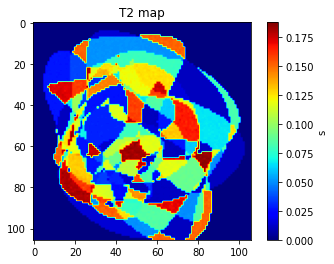

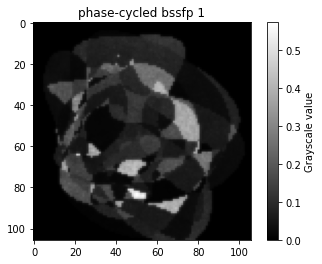

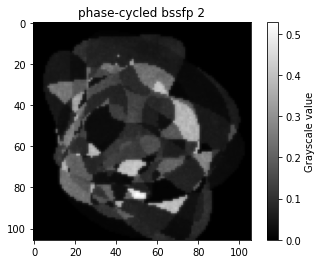

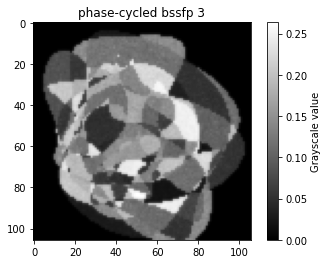

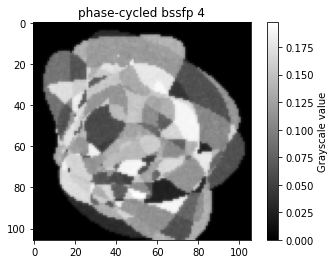

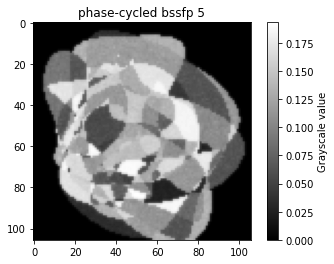

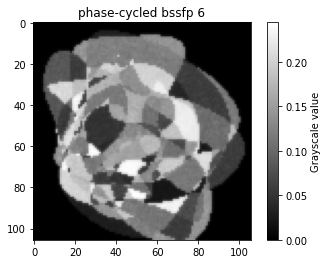

In [10]:
for i in range(new_image.shape[0]):
    plt.figure()  
    if i == 0:  
        plt.imshow(np.abs(new_image[i,:,:]), cmap='jet')
        plt.colorbar(label='s')
        plt.title('T2 map')
    else:  
        plt.imshow(np.abs(new_image[i,:,:]), cmap='gray')
        plt.colorbar(label='Grayscale value')
        plt.title(f'phase-cycled bssfp {i}')
    plt.show()